# Transformers and their Attention Mechanisms

- Transformer Architecture was first proposed in [Attention is all you need](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017)
- Has revolutionized NLP and by now most other areas of Deep Learning, i.e. Computer Vision, Speech Recognition, etc.
- Made large-scale deep learning models feasible and numerically stable (e.g. GPT-4, PaLM, etc.)

![Original Proposed Encoder-Decoder Architecture](./images/aiayn.jpeg)


In [1]:
import pandas as pd
import numpy as np
from seaborn import heatmap
from plotting import better_scatter_plot
from sklearn.manifold import TSNE
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

# Set super-random seed
np.random.seed(123)
torch.random.manual_seed(123)

# Set the figsize globally
plt.rcParams["figure.figsize"] = (20, 20)

# And load bert-base-uncased from huggingface
model_name: str = "bert-base-uncased"

# We need to specify some hyperparameters used to construct BERT
# d_k is the dimension of the keys later on and is used for scaling the dot products
# before applying the softmax, this gives better gradients
d_k: int = 64

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Tokens and Embeddings

In Language Modeling, words are *tokenized*, i.e. broken down into smaller units which are then encoded as integers.
Transformers then learn *embeddings* for these tokens, i.e. vectors in $\mathbb{R}^{d_m}$ where $d_m$ is the model's hidden dimension.

In [2]:
tokenizer.tokenize("High-dimensional visualizations of data.")

['high', '-', 'dimensional', 'visual', '##izations', 'of', 'data', '.']

In [3]:
text = """
We present a new technique called 't-SNE' that visualizes high-dimensional data by giving each datapoint a location in a two or three-dimensional map. The technique is a variation of Stochastic Neighbor Embedding (Hinton and Roweis, 2002) that is much easier to optimize, and produces significantly better visualizations by reducing the tendency to crowd points together in the center of the map. t-SNE is better than existing techniques at creating a single map that reveals structure at many different scales. This is particularly important for high-dimensional data that lie on several different, but related, low-dimensional manifolds, such as images of objects from multiple classes seen from multiple viewpoints. For visualizing the structure of very large data sets, we show how t-SNE can use random walks on neighborhood graphs to allow the implicit structure of all of the data to influence the way in which a subset of the data is displayed. We illustrate the performance of t-SNE on a wide variety of data sets and compare it with many other non-parametric visualization techniques, including Sammon mapping, Isomap, and Locally Linear Embedding. The visualizations produced by t-SNE are significantly better than those produced by the other techniques on almost all of the data sets.
"""

tokens = tokenizer.encode(text, return_tensors="pt")
decoded_tokens = tokenizer.convert_ids_to_tokens(tokens[0].numpy())

df = pd.DataFrame(
    {
        "Token": decoded_tokens,
        "Token ID": tokens[0].numpy(),
    }
)

print(
    "{} tokens from {} words (counted by spaces)".format(
        len(df), text.count(" ") + 1
    )
)

df

271 tokens from 202 words (counted by spaces)


,Token,Token ID
0,[CLS],101
1,we,2057
2,present,2556
3,a,1037
4,new,2047
...,...,...
266,the,1996
267,data,2951
268,sets,4520
269,.,1012


In [4]:
model.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [5]:
with_embeddings = df.assign(
    token_embeddings=list(
        model.embeddings.word_embeddings(tokens).detach().numpy()[0]
    ),
    position_embeddings=list(
        model.embeddings.position_embeddings(torch.arange(tokens.shape[1]))
        .detach()
        .numpy()
    ),
    final_embeddings=list(model.embeddings(tokens).detach().numpy()[0]),
)

with_embeddings.head(5)

,Token,Token ID,token_embeddings,position_embeddings,final_embeddings
0,[CLS],101,"[0.013630296, -0.026490416, -0.023503132, -0.0...","[0.017505383, -0.025631009, -0.036641564, -0.0...","[0.16855061, -0.28576738, -0.32612568, -0.1122..."
1,we,2057,"[-0.056419022, 0.006277898, -0.05258818, -0.01...","[0.0077580423, 0.0022613, -0.019444324, -0.017...","[-0.6375448, 0.5414745, -0.8719403, -0.2373216..."
2,present,2556,"[-0.043012902, 0.029432377, -0.042622253, -0.0...","[-0.011287465, -0.001964414, -0.011572698, -0....","[-0.6258968, 0.8418481, -0.48080346, -1.259853..."
3,a,1037,"[0.015209605, 0.008183979, 0.004319421, 0.0108...","[-0.0041948934, -0.011852281, -0.0211802, -0.0...","[0.39637807, 0.31565616, 0.020089187, 0.345666..."
4,new,2047,"[-0.011647389, -0.028420446, 0.016058497, -0.0...","[-0.005608681, -0.010445193, -0.0072287684, -0...","[-0.0297935, -0.21025068, 0.50215954, 0.235777..."


## (Quick Detour) Transformer Models learn *good* high-dimensional embeddings for the words

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


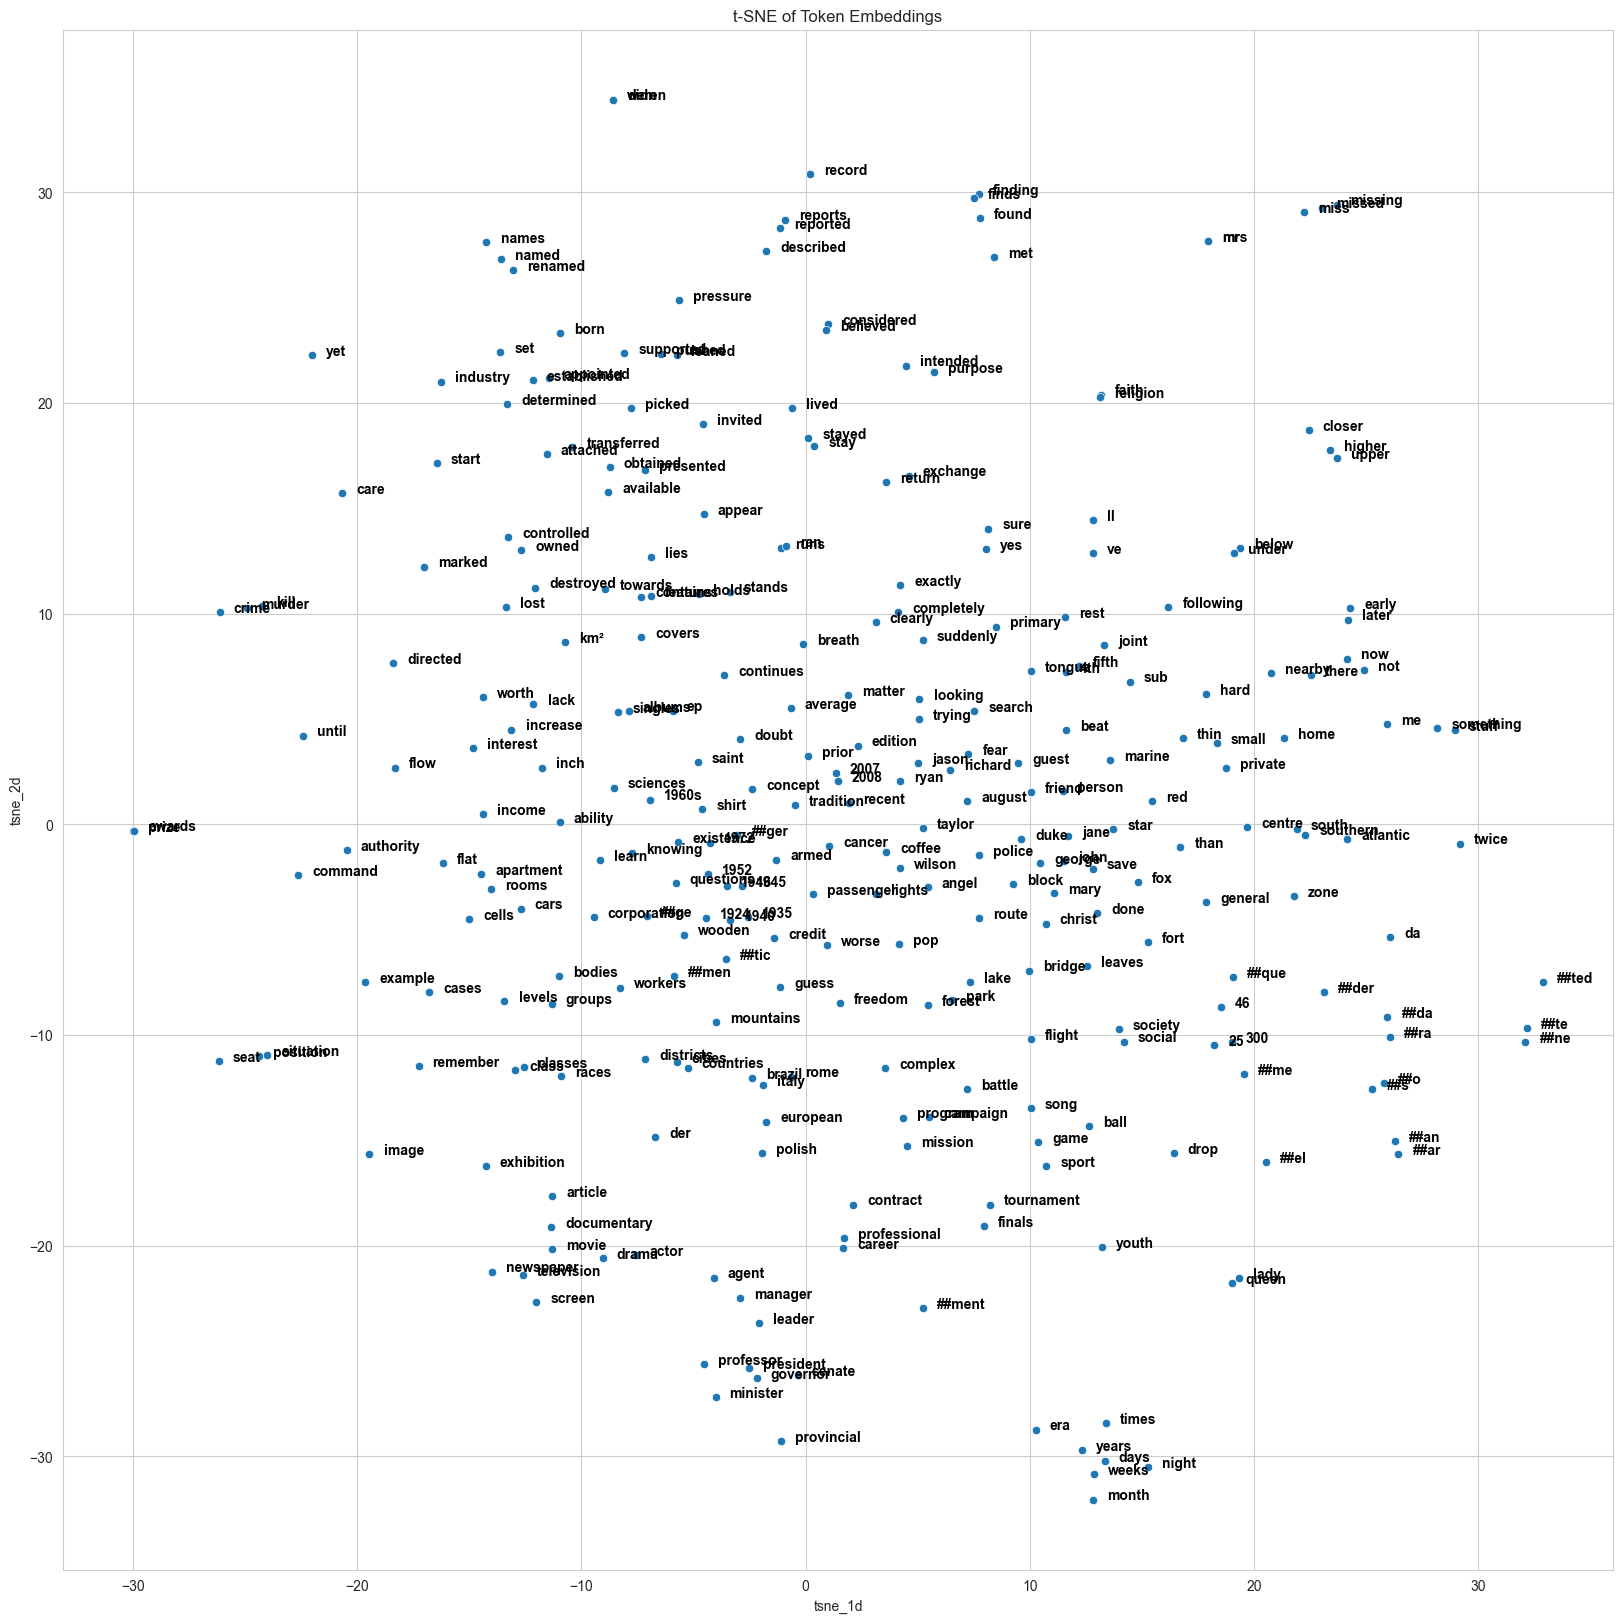

In [6]:
n_random_tokens: int = 300
start_idx: int = 2_000
np.random.seed(123)

random_token_ids = np.random.choice(
    np.arange(start_idx, start_idx + 3_000), replace=False, size=n_random_tokens
)
decoded_random_tokens = [tokenizer.decode(t) for t in random_token_ids]
d = pd.DataFrame(
    {
        "Token": decoded_random_tokens,
    }
)

tsne = TSNE(n_components=2, perplexity=10, random_state=123, n_iter=10_000)
tsne_vectors = tsne.fit_transform(
    model.embeddings.word_embeddings(torch.tensor(random_token_ids)[None, :])
    .detach()[0]
    .numpy()
)

with_tsne_embeddings = d.assign(
    tsne_1d=tsne_vectors[:, 0],
    tsne_2d=tsne_vectors[:, 1],
)

better_scatter_plot(
    with_tsne_embeddings,
    label_col="Token",
    x_col="tsne_1d",
    y_col="tsne_2d",
    plot_title="t-SNE of Token Embeddings",
    hue=None,
)

Recall: We now have embedded our words to tokens and these tokens to vectors.

We yield a list of vectors in $\mathbb{R}^{768}$ for each token, i.e. a matrix $X \in \mathbb{R}^{n \times 768}$ for $n$ tokens.

# The Attention Mechanism of Transformer Models

Transformer models *learn these embeddings* natively and place them accordingly in the vector space.

In [7]:
np.stack(with_embeddings["final_embeddings"].values).shape

(271, 768)

The Attention Mechanism works like a *database lookup* in which the so-called attention head may query arbitrary information 
*from any token in the sequence to any other token in the sequence*.
This works as follows (in one attention head for simplicity):

1. raw embeddings are linearly projected to form $Q, K, V$, the so-called queries, keys and values
2. queries and keys are matched via dot products which are taken between every query and every key, this gives a square matrix in $\mathbb{R}^{n \times n}$
3. we apply the softmax function so that the matrices' rows sum to one and yield the attention matrix $A$, which is a right-stochastic matrix
4. compute $A \cdot V$, in this step information is transferred from token $j$ to token $i$ if and only if $A_{ij}$ is large compared to the other entries in the row of the Attention Matrix
5. The output of the Attention Head is then again, linearly projected using another *learned matrix* to yield the final output of the attention head

$$Y = (A \cdot V) \cdot W^O$$

where $W^O$ is the learned, output projection matrix.

To be precise, technically we also add learned biases when forming $Q, K, V$. So generally, these are *affine transformations*.

> This way the Attention Mechanism can *arbitrarily* mix information within the sequence depending on certain features present in the embeddings


In [8]:
# Our initial embeddings (token embeddings + positional encoding + token type embeddings then LayerNorm and Dropout)
X = np.stack(with_embeddings["final_embeddings"].values)
X = torch.as_tensor(X)

attention_module = model.encoder.layer[0].attention.self
# head: int = 11

with torch.no_grad():
    # Compute our Queries, Keys and Values
    # Q = attention_module.query(X)[:, head * d_k : (head + 1) * d_k]
    # K = attention_module.key(X)[:, head * d_k : (head + 1) * d_k]
    # V = attention_module.value(X)[:, head * d_k : (head + 1) * d_k]
    Q = attention_module.query(X)
    K = attention_module.key(X)
    V = attention_module.value(X)

Q.shape, K.shape, V.shape

(torch.Size([271, 768]), torch.Size([271, 768]), torch.Size([271, 768]))

Now we compute our attention matrix $A$

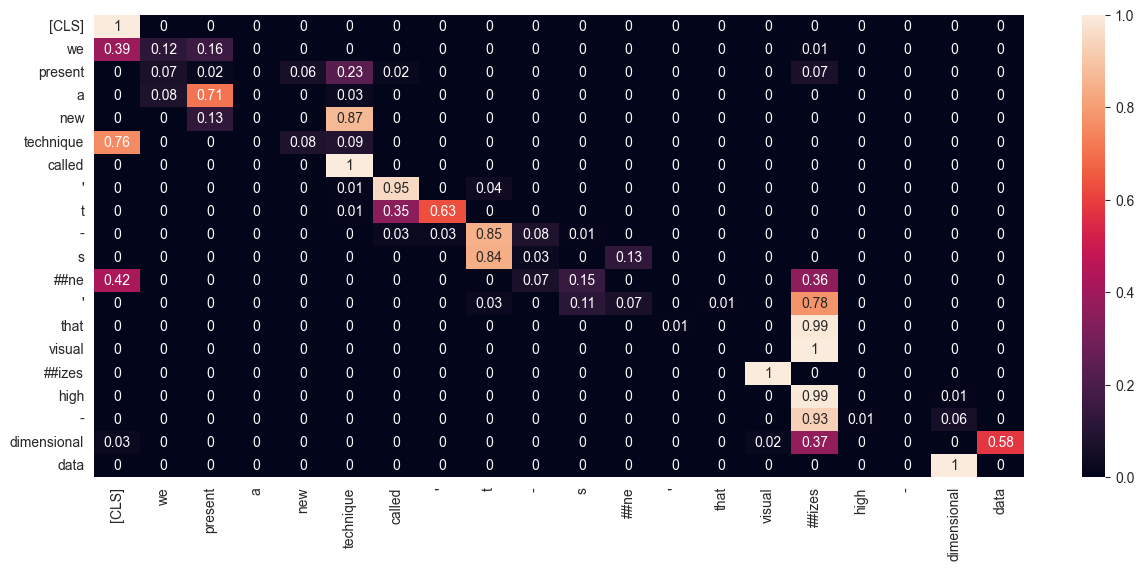

In [9]:
A = Q @ K.T
A = A / np.sqrt(d_k)  # Normalize as in the original paper

# And apply the softmax row-wise
A = torch.exp(A)
A = A / torch.sum(A, axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(15, 6))

n_first: int = 20
_ = heatmap(
    data=pd.DataFrame(
        data=np.array(A), index=decoded_tokens, columns=decoded_tokens
    )
    .iloc[:n_first, :n_first]
    .round(2),
    ax=ax,
    annot=True,
)

As we can see in the above example, the attention head queries information from the token 'technique' and assigns it to the embedding of the token 'called'.
To better understand the word t-SNE (which is encoded as three tokens, 't', '-', 's', '##ne'), this attention head queries from 't' to both '-' and 's'.

What is powerful is that this mechanism can query the same token to multiple locations. As we can see in the example, all of the tokens '##ne', "'", 'that', 'visual', 'high', '-', and 'dimensional' query information from the token '##izes'.

However, what features exactly are queried is quite hard to quantify as the raw embeddings are first projected to the values, then queried accordingly (and mixed using the attention matrix) and then again linearly projected using $W^{O}$.

## Transformer Block

As we can see below, large Transformers consist of many stacked so-called Transformer Blocks (or layers).

Each of them
1. applies Multi-Head Attention (as described above), and then
2. applies a Feed-Forward Network by projecting embeddings onto $\mathbb{R}^{4 \cdot d_m}$, applying an activation function and then projecting them back to $\mathbb{R}^{d_m}$

In between the model uses Layer Normalization to achieve better gradients (especially as layers are stacked) and Dropout to prevent overfitting.

To be more precise, we actually apply the attention mechanism multiple times in parallel, in total using 12 attention heads.
For this however, we only need to slice the linearly transformed $Q, K, V$ along the feature dimension before applying the attention matrix.

In [10]:
model.encoder.layer[0]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [11]:
# Load GPT-2 from huggingface
from transformers import AutoModelForCausalLM

generative_model_name: str = "gpt2"

t = AutoTokenizer.from_pretrained(generative_model_name)
m = AutoModelForCausalLM.from_pretrained(generative_model_name)


In [12]:
prompt_text: str = "Transformers are state-of-the-art language models, they"
prompt_tokens = t.encode(prompt_text, return_tensors="pt")

with torch.no_grad():
    # We get the logits for *every token in the sequence*
    y = m.forward(prompt_tokens).logits[0, -1]

p = torch.softmax(y, dim=0).numpy()

k: int = 20
# Get the top 10 tokens and decode them
top_tokens = np.argsort(p)[-k:]

# Get the top 10 probabilities
top_probs = p[top_tokens]
top_tokens = [t.decode(token) for token in top_tokens]

pd.DataFrame(
    {
        "Token": top_tokens,
        "Probability": top_probs,
    }
).sort_values("Probability", ascending=False)

,Token,Probability
19,are,0.176456
18,can,0.126802
17,'re,0.094283
16,have,0.049225
15,provide,0.039928
14,allow,0.024241
13,don,0.015047
12,do,0.013431
11,offer,0.012880
10,use,0.012567


## How is this used in Computer Vision?

- Vision Transformer (ViT), first proposed in [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) by Dosovitskiy et al. (2020) linearly projects blocks of pixels to form local embeddings that can then be used in the model
- Can be used in classification tasks and outperforms CNNs which have been the previous SOTA for a long time

![ViT Architecture](./images/vit.png)